## Example 7: Henon-Heiles Hamiltonian (Anharmonic oscillator) by Sine-DVR

In dimensionless form, the Henon-Heiles Hamiltonian is given by

$$
\hat{H} = \frac{\omega}{2}\sum_{i=1}^{f} \left( - \frac{\partial^2}{\partial Q_i^2} + Q_i^2 \right) + \lambda \left( \sum_{i=1}^{f-1} Q_i^2 Q_{i+1} - \frac{1}{3} Q_{i+1}^3 \right)
$$

But PyTDSCF adopts mass-weighted coordinate, thus the Hamiltonian is given by

$$
\hat{H} = \frac{1}{2}\sum_{i=1}^{f} \left( - \frac{\partial^2}{\partial q_i^2} + \omega^2 q_i^2 \right) + \lambda \omega^{\frac{3}{2}} \left( \sum_{i=1}^{f-1} q_i^2 q_{i+1} - \frac{1}{3} q_{i+1}^3 \right)
$$

where $Q_i = \sqrt{\omega} q_i$.



| run type      | wavefunction | backend | Basis  | steps |
| ---           | ---          | ---     | ---    | ---   |
| propagation | MPS-SM | Numpy   | Sine-DVR | 400    |

### 1. Define parameters
```
    ω (float): frequency in a.u.
    λ (float): coupling strength in a.u.
    f (int): degree of freedom
    N (int): number of grid points for each degree of freedom
    m (int): MPS bond dimension
    Δt (float): time step size in femtosecond. If spectrum norm of Hamiltonian is large, Δt should be smaller.
```

In [1]:
ω_au = 1.0
λ_au = 0.111803
f = 4
N = 24
m = 10
Δt_fs = 0.00025
backend = "numpy"

### 2. Import modules

In [2]:
from typing import Callable

from discvar import Sine

from pytdscf import Model, Simulator, __version__
from pytdscf.dvr_operator_cls import (
    construct_kinetic_mpo,
    construct_nMR_recursive,
)

__version__

'1.2.3'

### 3. Define Sine-DVR grid basis set

DVR function documentation is [here](https://qclovers.github.io/PyTDSCF/pytdscf.dvr_primitives.html#pytdscf.dvr_primitives.sin)

In [3]:
dvr_prims = [
    Sine(N, length=16.0, x0=-8.0, units="a.u.", include_terminal=True)
    for _ in range(f)
]

**Plot Sine-DVR**

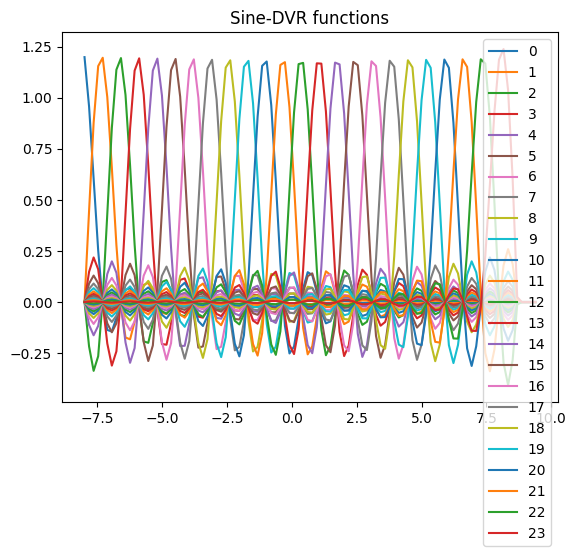

In [4]:
dvr_prims[0].plot_dvr()

### 4. Define Anharmonic potential

- If you use different frequencyies, be careful to "late binding" of Python.

In [5]:
# Potential Function of each degree of freedom pair
henon_heiles_func: dict[tuple[int, ...], Callable] = {}
for idof in range(f):
    if idof == 0:
        henon_heiles_func[(0,)] = lambda Q1: pow(ω_au, 2) / 2 * Q1**2
        if f > 1:
            henon_heiles_func[(0, 1)] = (
                lambda Q1, Q2: λ_au * pow(ω_au, 3 / 2) * (Q1**2 * Q2)
            )
    elif idof == f - 1:
        henon_heiles_func[(f - 1,)] = (
            lambda Qf: pow(ω_au, 2) / 2 * Qf**2
            - λ_au * pow(ω_au, 3 / 2) / 3 * Qf**3
        )
    else:
        henon_heiles_func[(idof,)] = (
            lambda Qi: pow(ω_au, 2) / 2 * Qi**2
            - λ_au * pow(ω_au, 3 / 2) / 3 * Qi**3
        )
        henon_heiles_func[(idof, idof + 1)] = (
            lambda Qi, Qi1: λ_au * pow(ω_au, 3 / 2) * (Qi**2 * Qi1)
        )

In [6]:
henon_heiles_func

{(0,): <function __main__.<lambda>(Q1)>,
 (0, 1): <function __main__.<lambda>(Q1, Q2)>,
 (1,): <function __main__.<lambda>(Qi)>,
 (1, 2): <function __main__.<lambda>(Qi, Qi1)>,
 (2,): <function __main__.<lambda>(Qi)>,
 (2, 3): <function __main__.<lambda>(Qi, Qi1)>,
 (3,): <function __main__.<lambda>(Qf)>}

### 5. Construct MPO

Refer to [this document](https://qclovers.github.io/PyTDSCF/pytdscf.html#pytdscf.dvr_operator_cls.construct_nMR_recursive) for more details of `construct_nMR_recursive` function.

In [7]:
mpo = construct_nMR_recursive(
    dvr_prims, nMR=2, func=henon_heiles_func, rate=0.99999999999
)

18:34:59 | INFO | scalar term 0.0 is excluded from MPO.
18:34:59 | INFO | DONE: construct 3 quasi full-dimensional MPOs
18:34:59 | INFO | 0-3: part of full-dimensional MPOs optimization
18:34:59 | INFO | Execute (24, 624) matrix SVD in 0-1 sites MPO optimization
18:34:59 | INFO | Execute (48, 624) matrix SVD in 1-2 sites MPO optimization
18:34:59 | INFO | Execute (96, 24) matrix SVD in 2-3 sites MPO optimization
18:34:59 | INFO | 0-1: full-dimensional MPOs optimization
18:34:59 | INFO | Execute (24, 72) matrix SVD in 0-1 sites MPO optimization
18:34:59 | INFO | Execute (48, 72) matrix SVD in 1-2 sites MPO optimization
18:34:59 | INFO | Execute (72, 24) matrix SVD in 2-3 sites MPO optimization
18:34:59 | INFO | 0-sweep: full-dimensional MPOs optimization
18:34:59 | INFO | final MPO bond-dimension [2, 3, 3]


In [8]:
for core in mpo:
    print(core.shape)

(1, 24, 2)
(2, 24, 3)
(3, 24, 3)
(3, 24, 1)


### 6. Define Hamiltonian

In [9]:
kin_mpo = construct_kinetic_mpo(dvr_prims)
operators = {"potential": mpo, "kinetic": kin_mpo}

### 7. Define model of Wavefunction and Operators

In [10]:
model = Model(dvr_prims, operators=operators, bond_dim=m)

**Initial state setting**
$$
\Psi(t=0)=\prod_j \left(\frac{\omega_j\pi}{4}\right)^{-\frac{1}{4}}\exp\left(-\frac{\omega_jx_j^2}{2}\right)
$$

In [11]:
import numpy as np


def get_initial_state(center, ω, x):
    weight = np.exp(-ω / 2 * (np.array(x) - center) ** 2)
    weight /= np.linalg.norm(weight)
    return weight.tolist()


centers = [2.0, 2.0, 0.0, 0.0]

model.init_weight_VIBSTATE = [
    [
        get_initial_state(center, ω_au, dvr_prim.get_grids())
        for center, dvr_prim in zip(centers, dvr_prims, strict=False)
    ]
]  # 1st and 2nd mode are displaced

### 8. Execute simulation

In [12]:
jobname = "henon_heiles"
simulator = Simulator(jobname=jobname, model=model, backend=backend)
simulator.propagate(maxstep=400, stepsize=Δt_fs)

18:34:59 | INFO | Log file is ./henon_heiles_prop/main.log
18:34:59 | INFO | Wave function is saved in wf_henon_heiles.pkl
18:34:59 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/400 [00:00<?, ?it/s]

18:34:59 | INFO | End     0 step; propagated    0.000 [fs]; AVG Krylov iteration: 6.00
18:35:01 | INFO | End   100 step; propagated    0.025 [fs]; AVG Krylov iteration: 6.75
18:35:03 | INFO | End   200 step; propagated    0.050 [fs]; AVG Krylov iteration: 6.75
18:35:05 | INFO | End   300 step; propagated    0.075 [fs]; AVG Krylov iteration: 6.75
18:35:07 | INFO | End   399 step; propagated    0.100 [fs]; AVG Krylov iteration: 7.00
18:35:07 | INFO | End simulation and save wavefunction
18:35:07 | INFO | Wave function is saved in wf_henon_heiles.pkl


(6.596282646653343, <pytdscf.wavefunction.WFunc at 0x113a62360>)

### 9. Check result

In [13]:
!ls {jobname}*

henon_heiles_HO-DVR.ipynb   henon_heiles_Sine-DVR.ipynb

henon_heiles_prop:
autocorr.dat     expectations.dat main.log         populations.dat


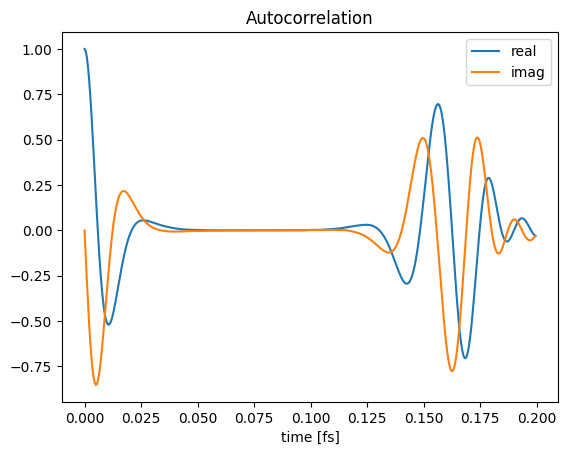

In [14]:
import matplotlib.pyplot as plt

from pytdscf import spectra

time, autocorr = spectra.load_autocorr(jobname + "_prop" + "/autocorr.dat")
plt.plot(time, autocorr.real, label="real")
plt.plot(time, autocorr.imag, label="imag")
plt.title("Autocorrelation")
plt.legend()
plt.xlabel("time [fs]")
plt.show()